In [44]:
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
import numpy as np

from PIL import Image
import os
import random
import torch.optim as optim

from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from art_generator.config import PROCESSED_DATA_DIR

import torchvision.utils as vutils

LOAD_MODEL_PATH = '20500_epoch'
SAVE_MODEL_PATH = '25000_epoch'

In [45]:
image_size = 256

dataset = ImageFolder(root=PROCESSED_DATA_DIR, 
                      transform=transforms.Compose([transforms.Resize(image_size),
                                                    transforms.CenterCrop(image_size),
                                                    transforms.ToTensor(),
                                                    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
                                                    ]))

In [46]:
batch_size = 128
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
device = "cuda" if torch.cuda.is_available() else "cpu"

In [47]:
from architectures import Generator, Critic

# Loading the generator
def load_generator(path, GeneratorClass):
    checkpoint = torch.load(path)
    generator = GeneratorClass()  # You need to define the generator architecture
    generator.load_state_dict(checkpoint['model_state_dict'])
    return generator

# Loading the generator
def load_critic(path, CriticClass):
    checkpoint = torch.load(path)
    critic = CriticClass()  # You need to define the generator architecture
    critic.load_state_dict(checkpoint['model_state_dict'])
    return critic

netG = load_generator( LOAD_MODEL_PATH + "/generator.pth", Generator)
netC = load_critic(LOAD_MODEL_PATH + "/critic.pth", Critic)
netG.to(device)
netC.to(device)

Critic(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (12): InstanceNorm2d(1024, eps=1e-05, momentum=0.1, affine=False, track_running_stats

In [48]:
# Architecture Params (also in architecture.py)

nz = 100
ngf = 64
nc = 3
ndf = 64

# Gradient penalty function
def compute_gradient_penalty(critic, real_samples, fake_samples):
    """Calculates the gradient penalty loss for WGAN-GP"""
    # Random weight term for interpolation between real and fake samples
    alpha = torch.rand(real_samples.size(0), 1, 1, 1, device=device)
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    critic_interpolates = critic(interpolates)
    fake = torch.ones(real_samples.size(0), 1, device=device, requires_grad=False)
    # Get gradient w.r.t. interpolates
    gradients = torch.autograd.grad(
        outputs=critic_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

# Wasserstein loss
def wasserstein_loss(y_pred, y_true):
    return torch.mean(y_true * y_pred)

fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Hyperparameters
lr = 5e-5
beta1 = 0.5
n_critic = 5  # Number of critic iterations per generator iteration
lambda_gp = 10  # Gradient penalty lambda hyperparameter

# Setup RMSProp optimizers for both G and C
optimizerD = optim.RMSprop(netC.parameters(), lr=lr)
optimizerG = optim.RMSprop(netG.parameters(), lr=lr)

In [49]:
# Training Loop
num_epochs = 4500
n_critic = 5  # number of critic iterations per generator iteration
lambda_gp = 10  # Gradient penalty lambda hyperparameter

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")

# Gradient penalty function
def compute_gradient_penalty(critic, real_samples, fake_samples):
    """Calculates the gradient penalty loss for WGAN-GP"""
    # Random weight term for interpolation between real and fake samples
    alpha = torch.rand(real_samples.size(0), 1, 1, 1, device=device)
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    critic_interpolates = critic(interpolates)
    # Create a tensor of ones with the same shape as critic_interpolates
    fake = torch.ones(critic_interpolates.size(), device=device, requires_grad=False)
    # Get gradient w.r.t. interpolates
    gradients = torch.autograd.grad(
        outputs=critic_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        
        ############################
        # (1) Update D network
        ###########################
        for _ in range(n_critic):
            netC.zero_grad()
            
            # Train with real
            real_images = data[0].to(device)
            b_size = real_images.size(0)
            
            # Train with fake
            noise = torch.randn(b_size, nz, 1, 1, device=device)
            fake = netG(noise)
            
            # Critic loss
            real_validity = netC(real_images).view(-1)
            fake_validity = netC(fake.detach()).view(-1)
            
            # Gradient penalty
            gradient_penalty = compute_gradient_penalty(netC, real_images.data, fake.data)
            
            # Wasserstein loss
            d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gradient_penalty
            
            d_loss.backward()
            optimizerD.step()

        ############################
        # (2) Update G network
        ###########################
        netG.zero_grad()
        
        # Generate fake images
        fake = netG(noise)
        # Loss measures generator's ability to fool the discriminator
        fake_validity = netC(fake).view(-1)
        g_loss = -torch.mean(fake_validity)
        
        g_loss.backward()
        optimizerG.step()
        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     d_loss.item(), g_loss.item()))

        # Save Losses for plotting later
        G_losses.append(g_loss.item())
        D_losses.append(d_loss.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/4500][0/3]	Loss_D: -371.6891	Loss_G: 1881.4585
[1/4500][0/3]	Loss_D: -689.0375	Loss_G: 2045.0154
[2/4500][0/3]	Loss_D: -653.2408	Loss_G: 2089.7876
[3/4500][0/3]	Loss_D: -635.2334	Loss_G: 2059.9038
[4/4500][0/3]	Loss_D: -575.7780	Loss_G: 2002.2081
[5/4500][0/3]	Loss_D: -491.2876	Loss_G: 2052.7085
[6/4500][0/3]	Loss_D: -546.7000	Loss_G: 2007.3237
[7/4500][0/3]	Loss_D: -563.3980	Loss_G: 1987.8231
[8/4500][0/3]	Loss_D: -501.9093	Loss_G: 1991.7285
[9/4500][0/3]	Loss_D: -511.9526	Loss_G: 1989.1479
[10/4500][0/3]	Loss_D: -536.0651	Loss_G: 1992.2522
[11/4500][0/3]	Loss_D: -508.5107	Loss_G: 1964.3748
[12/4500][0/3]	Loss_D: -464.4918	Loss_G: 1984.8066
[13/4500][0/3]	Loss_D: -452.8562	Loss_G: 2036.0703
[14/4500][0/3]	Loss_D: -464.3695	Loss_G: 1963.0068
[15/4500][0/3]	Loss_D: -460.4298	Loss_G: 1958.7441
[16/4500][0/3]	Loss_D: -444.8984	Loss_G: 1959.3558
[17/4500][0/3]	Loss_D: -452.8054	Loss_G: 1972.0059
[18/4500][0/3]	Loss_D: -376.2209	Loss_G: 1951.0245
[19/4500][0/3]	

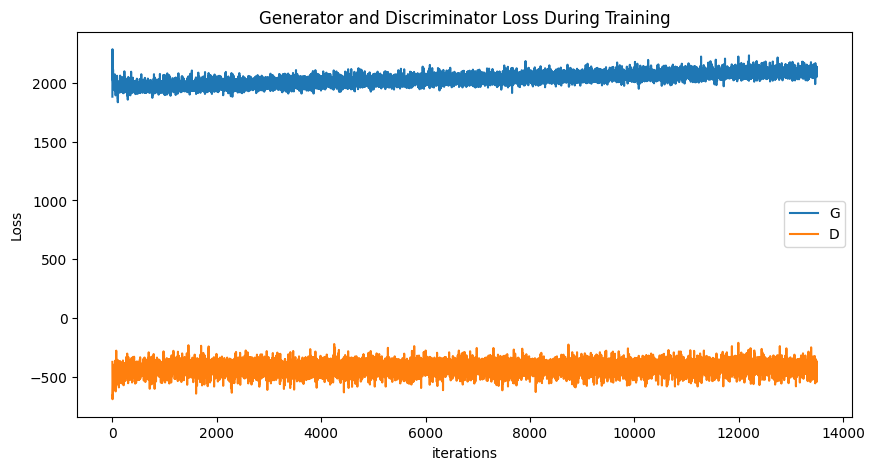

In [50]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

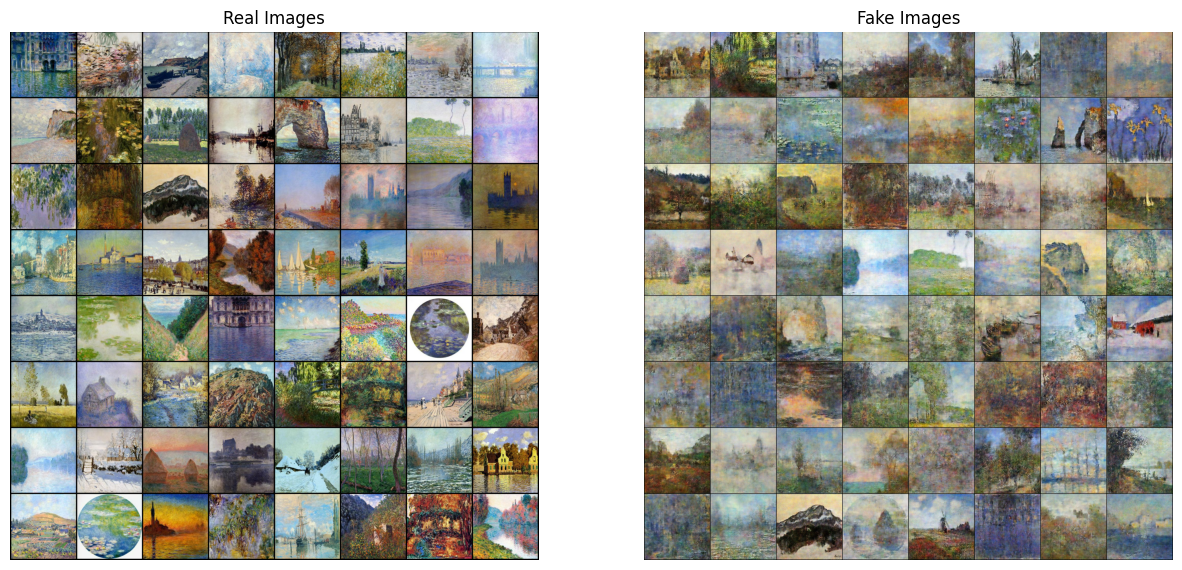

In [51]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(), (1, 2, 0)))

# Plot the fake images from the last epoch
plt.subplot(1, 2, 2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1], (1, 2, 0)))
plt.show()

In [52]:
# Saving the generator
def save_model(model, path):
    torch.save({
        'model_state_dict': model.state_dict(),
        'model_architecture': str(model),  # Save architecture as string
        # Add any other information you want to save
    }, path)

In [54]:
save_model(netG, SAVE_MODEL_PATH + '/generator.pth')
save_model(netC, SAVE_MODEL_PATH + '/critic.pth')